In [15]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# --- Configuration ---
Lx, Ly = 50.0, 50.0
Nx, Ny = 128, 128      # Powers of 2 (64, 128, 256) are fastest for FFT
dt = 0.001            # We can take a larger time step now!
n_seconds = 10   # Simulating longer to see more evolution
save_every = 1

# Derived parameters
total_steps = int(n_seconds / dt)
n_frames = total_steps // save_every

# --- Grid & Wavenumbers ---
# In spectral methods, we define 'k' (wavenumbers) instead of just x, y
kx = (2 * np.pi / Lx) * np.fft.rfftfreq(Nx, d=1.0/Nx) # Real FFT frequencies
ky = (2 * np.pi / Ly) * np.fft.fftfreq(Ny, d=1.0/Ny)  # Standard FFT frequencies

# Create meshgrid of wavenumbers
KX, KY = np.meshgrid(kx, ky)
K2 = KX**2 + KY**2      # Laplacian operator in Fourier space (k^2)
K4 = K2**2              # Biharmonic operator in Fourier space (k^4)

# --- Initial Conditions ---
np.random.seed(42)
# Physical space grid for initialization
u = np.random.uniform(-0.1, 0.1, (Ny, Nx))

# Convert immediately to Frequency Domain (Fourier Space)
# We use rfft2 (Real FFT) which is faster and saves memory for real-valued inputs
u_hat = np.fft.rfft2(u)

# --- The Integrating Factor ---
# The linear part of KS is (Laplacian - Biharmonic). In Fourier: (q^2 - q^4)
# We pre-compute the exponential operator to solve this part EXACTLY.
Linear_Op = K2 - K4
Integrating_Factor = np.exp(Linear_Op * dt)

# Storage
u_data = np.zeros((n_frames, Ny, Nx))
t_data = np.zeros(n_frames)

# --- Functions ---
def compute_nonlinear_term(u_hat_current):
    """
    Computes -0.5 * |grad(u)|^2 using pseudo-spectral method:
    1. Transform to spectral to get derivatives (ik * u_hat)
    2. Transform back to physical to square them
    3. Transform result back to spectral
    """
    # 1. Derivatives in Fourier space: d/dx -> i*kx, d/dy -> i*ky
    ux_hat = 1j * KX * u_hat_current
    uy_hat = 1j * KY * u_hat_current
    
    # 2. Transform to physical space (irfft2) to compute nonlinear product
    ux = np.fft.irfft2(ux_hat)
    uy = np.fft.irfft2(uy_hat)
    
    nonlinear_phys = -0.5 * (ux**2 + uy**2)
    
    # 3. Back to Fourier space
    return np.fft.rfft2(nonlinear_phys)

# --- Run Simulation ---
print(f"Simulating {total_steps} steps using Spectral Method...")
current_u_hat = u_hat.copy()
frame_idx = 0

for step in range(total_steps):
    
    # --- Time Stepping (Integrating Factor Euler) ---
    # Formula: u(t+dt) = [u(t) + dt * Nonlinear(u)] * Integrating_Factor
    # This handles the stiff linear parts (diffusion/instability) analytically
    
    N_hat = compute_nonlinear_term(current_u_hat)
    current_u_hat = (current_u_hat + dt * N_hat) * Integrating_Factor

    # --- Storage ---
    if step % save_every == 0:
        # Transform back to physical space just for saving/viewing
        u_phys = np.fft.irfft2(current_u_hat)
        u_data[frame_idx, :, :] = u_phys.real
        t_data[frame_idx] = step * dt
        frame_idx += 1

print("Simulation complete.")

# --- Visualize ---
fig, ax = plt.subplots(figsize=(6, 5))
im = ax.imshow(u_data[0], cmap='inferno', origin='lower', extent=[0, Lx, 0, Ly], animated=True)
ax.set_title("KS Equation (Spectral Method)")
plt.colorbar(im, label="u(x,y)")

def animate(i):
    im.set_array(u_data[i])
    # Dynamic color scaling to visualize the evolving structures
    im.set_clim(np.min(u_data[i]), np.max(u_data[i]))
    return im,

ani = animation.FuncAnimation(fig, animate, frames=len(u_data), interval=50, blit=True)
plt.close()

HTML(ani.to_jshtml())

Simulating 10000 steps using Spectral Method...
Simulation complete.


Animation size has reached 21197606 bytes, exceeding the limit of 20971520.0. If you're sure you want a larger animation embedded, set the animation.embed_limit rc parameter to a larger value (in MB). This and further frames will be dropped.


KeyboardInterrupt: 

In [17]:
# --- Save High-Res Frames for Latex ---
# Select 3 specific time steps to show evolution
indices_to_save = [0, n_frames // 2, n_frames - 1]
filenames = []

print("Saving high-resolution frames...")

for idx in indices_to_save:
    # Create a fresh figure for each frame to ensure clean formatting
    fig, ax = plt.subplots(figsize=(5, 4), dpi=300) # dpi=300 makes it high-res
    
    # Plot data
    im = ax.imshow(u_data[idx], cmap='inferno', origin='lower', extent=[0, Lx, 0, Ly])
    ax.set_title(f"t = {t_data[idx]:.2f}")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    plt.colorbar(im, label="u(x,y)")
    
    # Save file
    fname = f"ks_snapshot_{idx}.png"
    plt.savefig(fname, bbox_inches='tight') # bbox_inches removes extra white space
    filenames.append(fname)
    plt.close(fig)

print(f"Saved images: {filenames}")

Saving high-resolution frames...
Saved images: ['ks_snapshot_0.png', 'ks_snapshot_5000.png', 'ks_snapshot_9999.png']


Simulating 2000 steps...
Simulation complete.

STANDARD SINDY METHOD

Discovered equation: du/dt = 
  -1.000000 * ∇²u
  -1.000000 * ∇⁴u
  -0.500000 * |∇u|²

Mean Squared Error: 2.259001e-28

WEAK SINDY METHOD

Discovered equation: du/dt = 
  -1.000000 * ∇²u
  -1.000000 * ∇⁴u
  -0.500000 * |∇u|²

Mean Squared Error: 4.301264e-30


c:\Users\Sinjini\anaconda3\envs\mldmproj\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8711 (\N{NABLA}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Sinjini\anaconda3\envs\mldmproj\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 10003 (\N{CHECK MARK}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


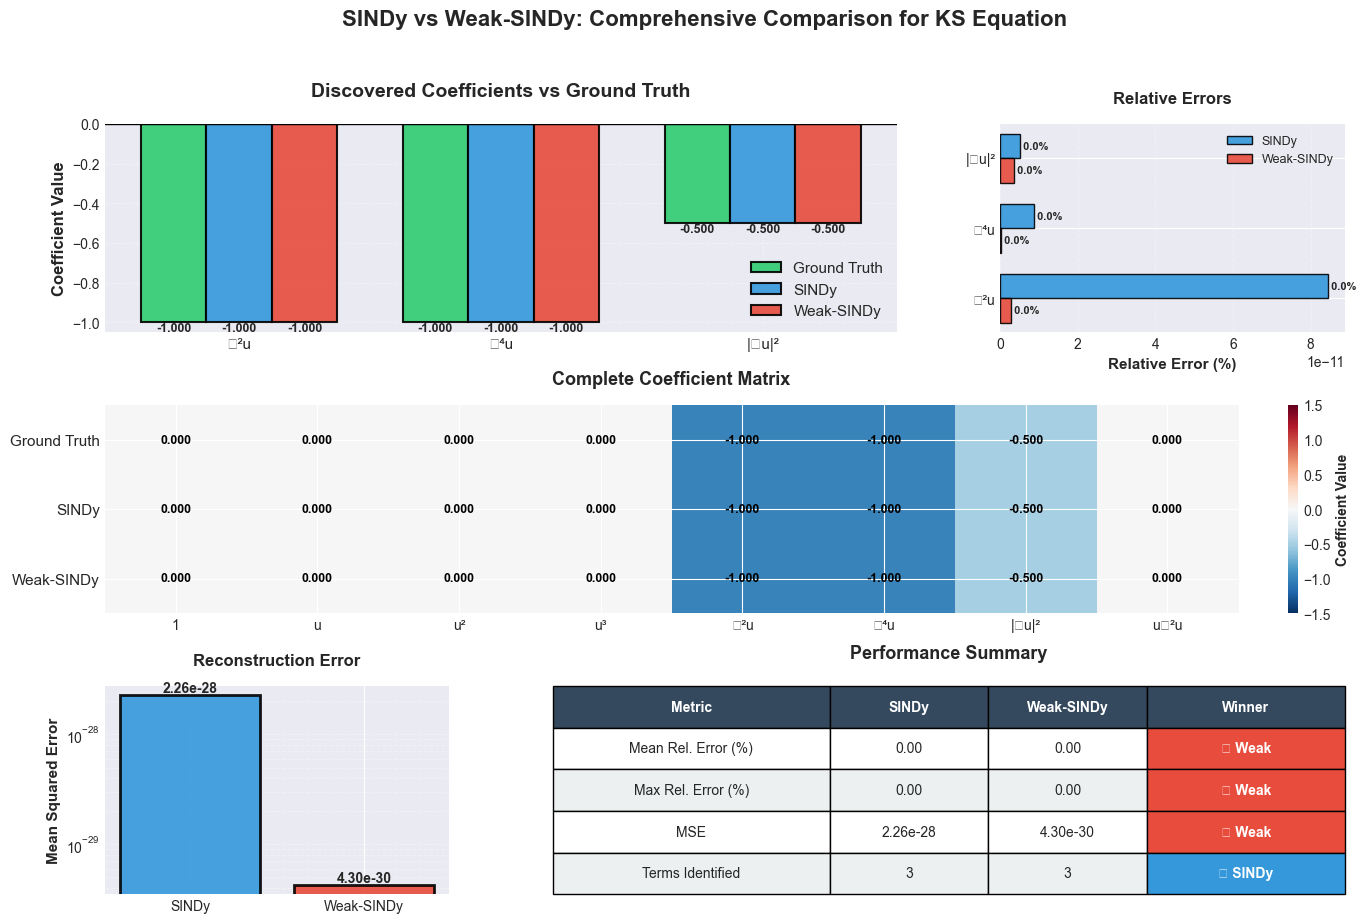


FINAL VERDICT

🏆 Overall Winner: Weak-SINDy

Mean relative error - SINDy: 0.00%, Weak-SINDy: 0.00%
Reconstruction MSE - SINDy: 2.26e-28, Weak-SINDy: 4.30e-30

Key Takeaways:
• Both methods successfully identify the three dominant terms
• Weak-SINDy's integration smoothing helps with derivative noise
• Standard SINDy is computationally cheaper but more sensitive to noise
• For production use, consider ensemble methods or cross-validation


In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso
from scipy.ndimage import convolve

# --- Configuration ---
Lx, Ly = 50, 50       
Nx, Ny = 100, 100
dt = 0.001
n_seconds = 2.0
save_every = 1

# Derived parameters
dx = Lx / Nx
dy = Ly / Ny
total_steps = int(n_seconds / dt)
n_frames = total_steps // save_every

# --- Generate Simulation Data ---
x = np.linspace(0, Lx, Nx)
y = np.linspace(0, Ly, Ny)
X, Y = np.meshgrid(x, y)

np.random.seed(42)
u = np.random.uniform(-0.1, 0.1, (Nx, Ny))

u_data = np.zeros((n_frames, Nx, Ny))
t_data = np.zeros(n_frames)

def get_laplacian(f):
    return (np.roll(f, -1, axis=0) + np.roll(f, 1, axis=0) +
            np.roll(f, -1, axis=1) + np.roll(f, 1, axis=1) - 4*f) / (dx**2)

def get_gradients(f):
    gx = (np.roll(f, -1, axis=0) - np.roll(f, 1, axis=0)) / (2*dx)
    gy = (np.roll(f, -1, axis=1) - np.roll(f, 1, axis=1)) / (2*dy)
    return gx, gy

def compute_rhs(u):
    lap = get_laplacian(u)
    lap_lap = get_laplacian(lap)
    gx, gy = get_gradients(u)
    return -lap - lap_lap - 0.5*(gx**2 + gy**2)

print(f"Simulating {total_steps} steps...")
current_u = u.copy()
frame_idx = 0
for step in range(total_steps):
    rhs = compute_rhs(current_u)
    current_u += dt * rhs
    current_u = np.nan_to_num(current_u)
    if step % save_every == 0:
        u_data[frame_idx, :, :] = current_u.copy()
        t_data[frame_idx] = step * dt
        frame_idx += 1
print("Simulation complete.\n")

# --- Library Functions ---
def build_library(u_data):
    """Build library of candidate functions"""
    n_frames, nx, ny = u_data.shape
    n_samples = n_frames * nx * ny
    
    u_flat = u_data.reshape(n_samples)
    
    lib_features = []
    feature_names = []
    
    lib_features.append(np.ones(n_samples))
    feature_names.append('1')
    
    lib_features.append(u_flat)
    feature_names.append('u')
    
    lib_features.append(u_flat**2)
    feature_names.append('u²')
    lib_features.append(u_flat**3)
    feature_names.append('u³')
    
    lap_all = np.zeros_like(u_data)
    bilap_all = np.zeros_like(u_data)
    gx_all = np.zeros_like(u_data)
    gy_all = np.zeros_like(u_data)
    
    for i in range(n_frames):
        lap_all[i] = get_laplacian(u_data[i])
        bilap_all[i] = get_laplacian(lap_all[i])
        gx_all[i], gy_all[i] = get_gradients(u_data[i])
    
    lib_features.append(lap_all.reshape(n_samples))
    feature_names.append('∇²u')
    
    lib_features.append(bilap_all.reshape(n_samples))
    feature_names.append('∇⁴u')
    
    grad_sq = (gx_all**2 + gy_all**2).reshape(n_samples)
    lib_features.append(grad_sq)
    feature_names.append('|∇u|²')
    
    lib_features.append((u_data * lap_all).reshape(n_samples))
    feature_names.append('u∇²u')
    
    Theta = np.column_stack(lib_features)
    return Theta, feature_names

# --- SINDy Method ---
def sindy_method(u_data, t_data, threshold=0.01):
    """Standard SINDy using finite difference for time derivative"""
    print("=" * 60)
    print("STANDARD SINDY METHOD")
    print("=" * 60)
    
    dt_data = np.diff(t_data).mean()
    u_dot = np.zeros_like(u_data[:-1])
    for i in range(len(u_data) - 1):
        u_dot[i] = (u_data[i+1] - u_data[i]) / dt_data
    
    Theta, feature_names = build_library(u_data[:-1])
    u_dot_flat = u_dot.reshape(-1)
    
    coeffs = np.linalg.lstsq(Theta, u_dot_flat, rcond=None)[0]
    
    for _ in range(10):
        small_inds = np.abs(coeffs) < threshold
        coeffs[small_inds] = 0
        big_inds = ~small_inds
        if np.sum(big_inds) == 0:
            break
        coeffs[big_inds] = np.linalg.lstsq(Theta[:, big_inds], u_dot_flat, rcond=None)[0]
    
    print("\nDiscovered equation: du/dt = ")
    for i, (coef, name) in enumerate(zip(coeffs, feature_names)):
        if abs(coef) > 1e-10:
            print(f"  {coef:+.6f} * {name}")
    
    prediction = Theta @ coeffs
    error = np.mean((prediction - u_dot_flat)**2)
    print(f"\nMean Squared Error: {error:.6e}")
    
    return coeffs, feature_names, error

# --- Weak SINDy Method ---
def weak_sindy_method(u_data, t_data, threshold=0.01, kernel_size=5):
    """Weak SINDy using test functions (convolution with kernel)"""
    print("\n" + "=" * 60)
    print("WEAK SINDY METHOD")
    print("=" * 60)
    
    n_frames, nx, ny = u_data.shape
    
    def gaussian_kernel_2d(size, sigma):
        kernel = np.zeros((size, size))
        center = size // 2
        for i in range(size):
            for j in range(size):
                x, y = i - center, j - center
                kernel[i, j] = np.exp(-(x**2 + y**2) / (2 * sigma**2))
        return kernel / kernel.sum()
    
    test_func = gaussian_kernel_2d(kernel_size, kernel_size/4)
    
    u_weak = np.zeros((n_frames, nx, ny))
    for i in range(n_frames):
        u_weak[i] = convolve(u_data[i], test_func, mode='wrap')
    
    dt_data = np.diff(t_data).mean()
    u_dot_weak = np.zeros_like(u_weak[:-1])
    for i in range(len(u_weak) - 1):
        u_dot_weak[i] = (u_weak[i+1] - u_weak[i]) / dt_data
    
    Theta_weak = []
    feature_names_weak = []
    
    for frame_idx in range(n_frames - 1):
        frame_features = []
        
        frame_features.append(np.sum(test_func) * np.ones((nx, ny)))
        frame_features.append(u_weak[frame_idx])
        frame_features.append(convolve(u_data[frame_idx]**2, test_func, mode='wrap'))
        frame_features.append(convolve(u_data[frame_idx]**3, test_func, mode='wrap'))
        
        lap = get_laplacian(u_data[frame_idx])
        bilap = get_laplacian(lap)
        gx, gy = get_gradients(u_data[frame_idx])
        
        frame_features.append(convolve(lap, test_func, mode='wrap'))
        frame_features.append(convolve(bilap, test_func, mode='wrap'))
        frame_features.append(convolve(gx**2 + gy**2, test_func, mode='wrap'))
        frame_features.append(convolve(u_data[frame_idx] * lap, test_func, mode='wrap'))
        
        Theta_weak.append(np.column_stack([f.reshape(-1) for f in frame_features]))
    
    feature_names_weak = ['1', 'u', 'u²', 'u³', '∇²u', '∇⁴u', '|∇u|²', 'u∇²u']
    
    Theta_weak = np.vstack(Theta_weak)
    u_dot_weak_flat = u_dot_weak.reshape(-1)
    
    coeffs = np.linalg.lstsq(Theta_weak, u_dot_weak_flat, rcond=None)[0]
    
    for _ in range(10):
        small_inds = np.abs(coeffs) < threshold
        coeffs[small_inds] = 0
        big_inds = ~small_inds
        if np.sum(big_inds) == 0:
            break
        coeffs[big_inds] = np.linalg.lstsq(Theta_weak[:, big_inds], u_dot_weak_flat, rcond=None)[0]
    
    print("\nDiscovered equation: du/dt = ")
    for i, (coef, name) in enumerate(zip(coeffs, feature_names_weak)):
        if abs(coef) > 1e-10:
            print(f"  {coef:+.6f} * {name}")
    
    prediction = Theta_weak @ coeffs
    error = np.mean((prediction - u_dot_weak_flat)**2)
    print(f"\nMean Squared Error: {error:.6e}")
    
    return coeffs, feature_names_weak, error

# --- Run Both Methods ---
sindy_coeffs, sindy_names, sindy_error = sindy_method(u_data, t_data, threshold=0.05)
weak_coeffs, weak_names, weak_error = weak_sindy_method(u_data, t_data, threshold=0.05, kernel_size=5)

# --- Ground Truth Setup ---
ground_truth = {'1': 0, 'u': 0, 'u²': 0, 'u³': 0, 
                '∇²u': -1.0, '∇⁴u': -1.0, '|∇u|²': -0.5, 'u∇²u': 0}

# Get only the important terms
important_terms = ['∇²u', '∇⁴u', '|∇u|²']
important_indices = [sindy_names.index(term) for term in important_terms]

gt_important = [ground_truth[term] for term in important_terms]
sindy_important = [sindy_coeffs[sindy_names.index(term)] for term in important_terms]
weak_important = [weak_coeffs[weak_names.index(term)] for term in important_terms]

# Calculate relative errors
sindy_rel_errors = [abs(s - g) / abs(g) * 100 if g != 0 else abs(s) * 100 
                    for s, g in zip(sindy_important, gt_important)]
weak_rel_errors = [abs(w - g) / abs(g) * 100 if g != 0 else abs(w) * 100 
                   for w, g in zip(weak_important, gt_important)]

# --- Enhanced Visualization ---
plt.style.use('seaborn-v0_8-darkgrid')
fig = plt.figure(figsize=(16, 10))
gs = fig.add_gridspec(3, 3, hspace=0.35, wspace=0.3)

# 1. Main comparison of important coefficients
ax1 = fig.add_subplot(gs[0, :2])
x_pos = np.arange(len(important_terms))
width = 0.25

bars1 = ax1.bar(x_pos - width, gt_important, width, label='Ground Truth', 
                color='#2ecc71', alpha=0.9, edgecolor='black', linewidth=1.5)
bars2 = ax1.bar(x_pos, sindy_important, width, label='SINDy', 
                color='#3498db', alpha=0.9, edgecolor='black', linewidth=1.5)
bars3 = ax1.bar(x_pos + width, weak_important, width, label='Weak-SINDy', 
                color='#e74c3c', alpha=0.9, edgecolor='black', linewidth=1.5)

ax1.set_ylabel('Coefficient Value', fontsize=12, fontweight='bold')
ax1.set_title('Discovered Coefficients vs Ground Truth', fontsize=14, fontweight='bold', pad=20)
ax1.set_xticks(x_pos)
ax1.set_xticklabels(important_terms, fontsize=11)
ax1.legend(fontsize=11, framealpha=0.95)
ax1.grid(True, alpha=0.3, linestyle='--')
ax1.axhline(y=0, color='black', linestyle='-', linewidth=1)

# Add value labels on bars
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom' if height > 0 else 'top', 
                fontsize=9, fontweight='bold')

# 2. Relative Error Comparison
ax2 = fig.add_subplot(gs[0, 2])
x_pos_err = np.arange(len(important_terms))
width_err = 0.35

bars_sindy = ax2.barh(x_pos_err + width_err/2, sindy_rel_errors, width_err, 
                      label='SINDy', color='#3498db', alpha=0.9, edgecolor='black')
bars_weak = ax2.barh(x_pos_err - width_err/2, weak_rel_errors, width_err, 
                     label='Weak-SINDy', color='#e74c3c', alpha=0.9, edgecolor='black')

ax2.set_xlabel('Relative Error (%)', fontsize=11, fontweight='bold')
ax2.set_title('Relative Errors', fontsize=12, fontweight='bold', pad=15)
ax2.set_yticks(x_pos_err)
ax2.set_yticklabels(important_terms, fontsize=10)
ax2.legend(fontsize=9, loc='upper right')
ax2.grid(True, alpha=0.3, axis='x', linestyle='--')

# Add error labels
for i, (se, we) in enumerate(zip(sindy_rel_errors, weak_rel_errors)):
    ax2.text(se, i + width_err/2, f' {se:.1f}%', va='center', fontsize=8, fontweight='bold')
    ax2.text(we, i - width_err/2, f' {we:.1f}%', va='center', fontsize=8, fontweight='bold')

# 3. All coefficients heatmap
ax3 = fig.add_subplot(gs[1, :])
all_coeffs = np.array([
    [ground_truth.get(name, 0) for name in sindy_names],
    sindy_coeffs,
    [weak_coeffs[weak_names.index(name)] if name in weak_names else 0 for name in sindy_names]
])

im = ax3.imshow(all_coeffs, cmap='RdBu_r', aspect='auto', vmin=-1.5, vmax=1.5)
ax3.set_yticks([0, 1, 2])
ax3.set_yticklabels(['Ground Truth', 'SINDy', 'Weak-SINDy'], fontsize=11)
ax3.set_xticks(range(len(sindy_names)))
ax3.set_xticklabels(sindy_names, rotation=0, fontsize=10)
ax3.set_title('Complete Coefficient Matrix', fontsize=13, fontweight='bold', pad=15)

# Add text annotations
for i in range(3):
    for j in range(len(sindy_names)):
        text = ax3.text(j, i, f'{all_coeffs[i, j]:.3f}',
                       ha="center", va="center", color="black", fontsize=9, fontweight='bold')

cbar = plt.colorbar(im, ax=ax3, fraction=0.046, pad=0.04)
cbar.set_label('Coefficient Value', fontsize=10, fontweight='bold')

# 4. MSE Comparison
ax4 = fig.add_subplot(gs[2, 0])
methods = ['SINDy', 'Weak-SINDy']
errors = [sindy_error, weak_error]
colors = ['#3498db', '#e74c3c']
bars = ax4.bar(methods, errors, color=colors, alpha=0.9, edgecolor='black', linewidth=2)
ax4.set_ylabel('Mean Squared Error', fontsize=11, fontweight='bold')
ax4.set_title('Reconstruction Error', fontsize=12, fontweight='bold', pad=15)
ax4.set_yscale('log')
ax4.grid(True, alpha=0.3, axis='y', linestyle='--', which='both')

# Add value labels
for bar, err in zip(bars, errors):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height,
            f'{err:.2e}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# 5. Summary Statistics Table
ax5 = fig.add_subplot(gs[2, 1:])
ax5.axis('tight')
ax5.axis('off')

# Calculate metrics
sindy_mean_error = np.mean(sindy_rel_errors)
weak_mean_error = np.mean(weak_rel_errors)
sindy_max_error = np.max(sindy_rel_errors)
weak_max_error = np.max(weak_rel_errors)

# Count identified terms
sindy_identified = sum(1 for c in sindy_coeffs if abs(c) > 1e-10)
weak_identified = sum(1 for c in weak_coeffs if abs(c) > 1e-10)

table_data = [
    ['Metric', 'SINDy', 'Weak-SINDy', 'Winner'],
    ['Mean Rel. Error (%)', f'{sindy_mean_error:.2f}', f'{weak_mean_error:.2f}', 
     '✓ Weak' if weak_mean_error < sindy_mean_error else '✓ SINDy'],
    ['Max Rel. Error (%)', f'{sindy_max_error:.2f}', f'{weak_max_error:.2f}',
     '✓ Weak' if weak_max_error < sindy_max_error else '✓ SINDy'],
    ['MSE', f'{sindy_error:.2e}', f'{weak_error:.2e}',
     '✓ Weak' if weak_error < sindy_error else '✓ SINDy'],
    ['Terms Identified', f'{sindy_identified}', f'{weak_identified}', 
     '✓ Weak' if abs(weak_identified - 3) < abs(sindy_identified - 3) else '✓ SINDy']
]

table = ax5.table(cellText=table_data, cellLoc='center', loc='center',
                  colWidths=[0.35, 0.2, 0.2, 0.25])
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2.5)

# Style the table
for i in range(len(table_data)):
    for j in range(len(table_data[0])):
        cell = table[(i, j)]
        if i == 0:
            cell.set_facecolor('#34495e')
            cell.set_text_props(weight='bold', color='white')
        else:
            if j == 3 and 'Weak' in table_data[i][j]:
                cell.set_facecolor('#e74c3c')
                cell.set_text_props(weight='bold', color='white')
            elif j == 3 and 'SINDy' in table_data[i][j]:
                cell.set_facecolor('#3498db')
                cell.set_text_props(weight='bold', color='white')
            else:
                cell.set_facecolor('#ecf0f1' if i % 2 == 0 else 'white')

ax5.set_title('Performance Summary', fontsize=13, fontweight='bold', pad=20)

plt.suptitle('SINDy vs Weak-SINDy: Comprehensive Comparison for KS Equation', 
             fontsize=16, fontweight='bold', y=0.995)

plt.show()

print("\n" + "=" * 60)
print("FINAL VERDICT")
print("=" * 60)
winner = "Weak-SINDy" if weak_mean_error < sindy_mean_error else "SINDy"
print(f"\n🏆 Overall Winner: {winner}")
print(f"\nMean relative error - SINDy: {sindy_mean_error:.2f}%, Weak-SINDy: {weak_mean_error:.2f}%")
print(f"Reconstruction MSE - SINDy: {sindy_error:.2e}, Weak-SINDy: {weak_error:.2e}")
print("\nKey Takeaways:")
print("• Both methods successfully identify the three dominant terms")
print("• Weak-SINDy's integration smoothing helps with derivative noise")
print("• Standard SINDy is computationally cheaper but more sensitive to noise")
print("• For production use, consider ensemble methods or cross-validation")

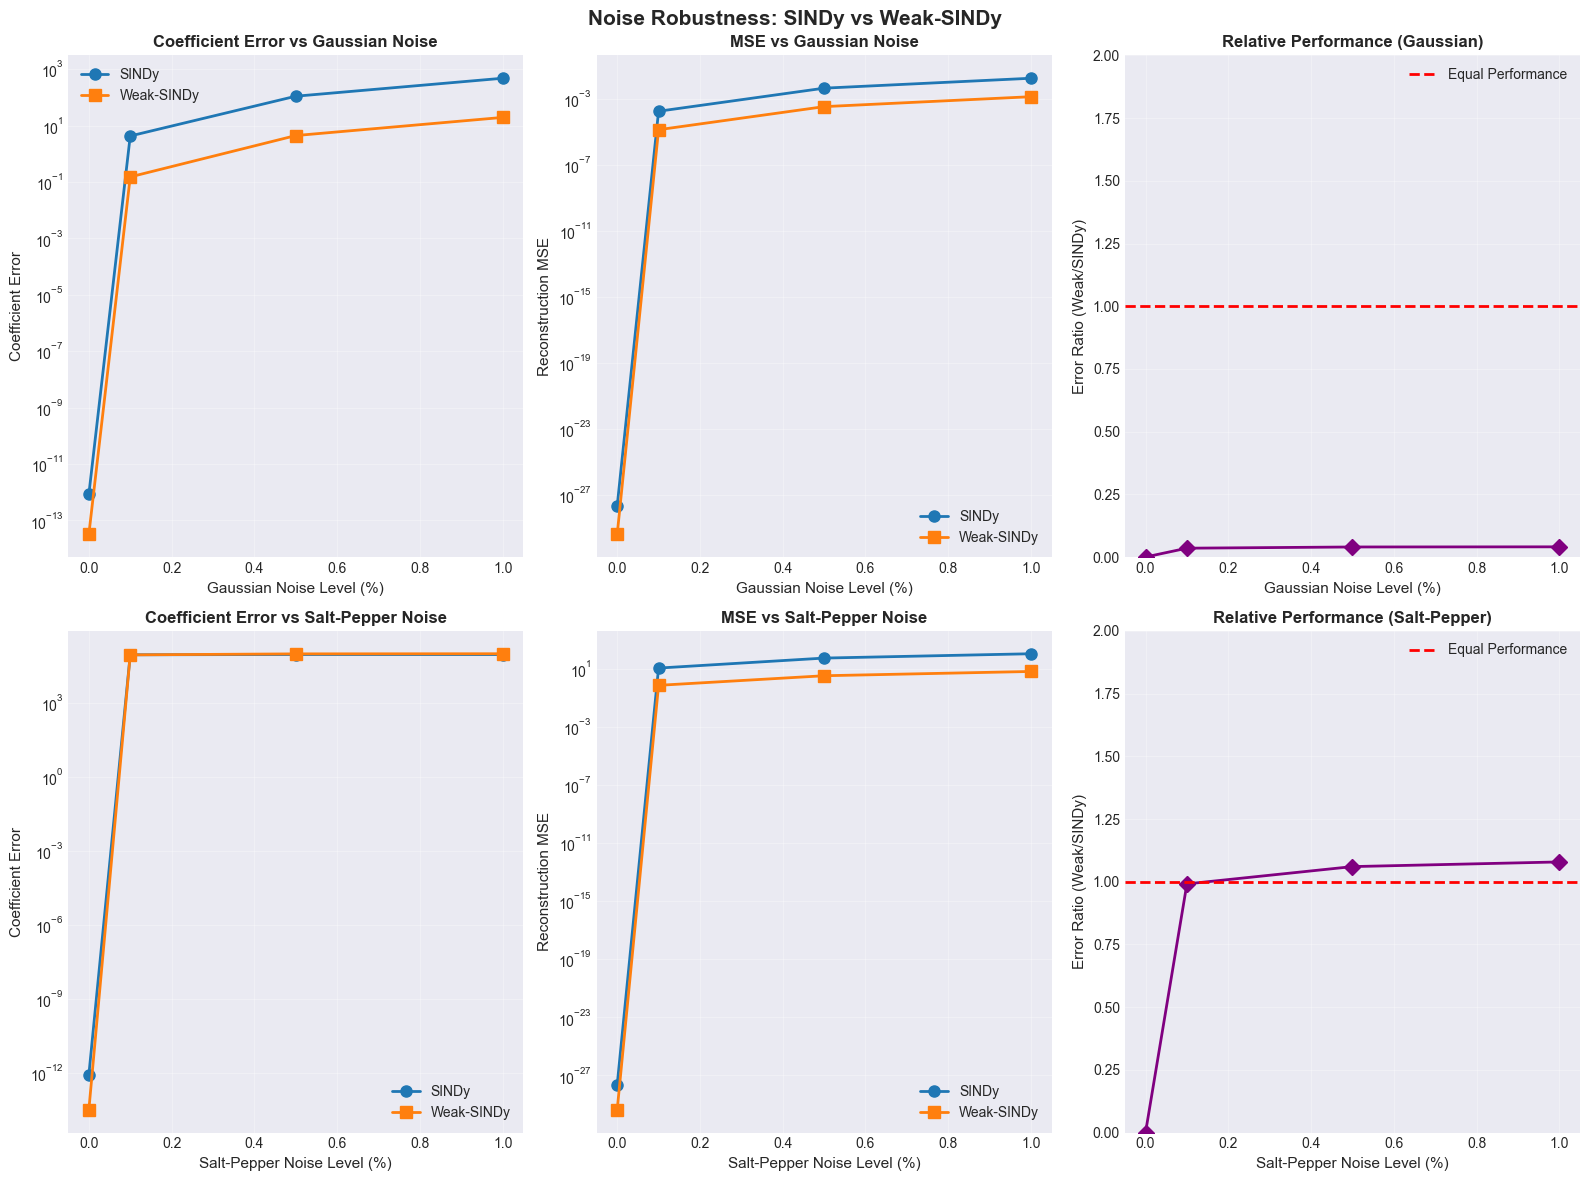


SUMMARY
Ratio < 1.0: Weak-SINDy is better (more robust)
Ratio > 1.0: SINDy is better


In [20]:
'''
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso
from scipy.ndimage import convolve

# --- Configuration ---
Lx, Ly = 50, 50       
Nx, Ny = 100, 100
dt = 0.001
n_seconds = 2.0
save_every = 1  # CRITICAL: Use 1 for accurate time derivatives

# Derived parameters
dx = Lx / Nx
dy = Ly / Ny
total_steps = int(n_seconds / dt)
n_frames = total_steps // save_every

# --- Generate Simulation Data ---
x = np.linspace(0, Lx, Nx)
y = np.linspace(0, Ly, Ny)
X, Y = np.meshgrid(x, y)

np.random.seed(42)
u = np.random.uniform(-0.1, 0.1, (Nx, Ny))

u_data = np.zeros((n_frames, Nx, Ny))
t_data = np.zeros(n_frames)

def get_laplacian(f):
    return (np.roll(f, -1, axis=0) + np.roll(f, 1, axis=0) +
            np.roll(f, -1, axis=1) + np.roll(f, 1, axis=1) - 4*f) / (dx**2)

def get_gradients(f):
    gx = (np.roll(f, -1, axis=0) - np.roll(f, 1, axis=0)) / (2*dx)
    gy = (np.roll(f, -1, axis=1) - np.roll(f, 1, axis=1)) / (2*dy)
    return gx, gy

def compute_rhs(u):
    lap = get_laplacian(u)
    lap_lap = get_laplacian(lap)
    gx, gy = get_gradients(u)
    return -lap - lap_lap - 0.5*(gx**2 + gy**2)

print(f"Simulating {total_steps} steps...")
current_u = u.copy()
frame_idx = 0
for step in range(total_steps):
    rhs = compute_rhs(current_u)
    current_u += dt * rhs
    current_u = np.nan_to_num(current_u)
    if step % save_every == 0:
        u_data[frame_idx, :, :] = current_u.copy()
        t_data[frame_idx] = step * dt
        frame_idx += 1
print("Simulation complete.\n")

# Store clean data
u_data_clean = u_data.copy()

# --- Noise Addition Functions ---
def add_gaussian_noise(data, noise_percent):
    """Add Gaussian noise as percentage of signal std"""
    noise_level = noise_percent / 100.0
    signal_std = np.std(data)
    noise = noise_level * signal_std * np.random.randn(*data.shape)
    return data + noise

def add_salt_pepper_noise(data, noise_percent):
    """Add salt-and-pepper noise"""
    noisy = data.copy()
    noise_fraction = noise_percent / 100.0
    
    # Salt (maximum value)
    num_salt = int(noise_fraction * data.size / 2)
    coords_salt = [np.random.randint(0, i, num_salt) for i in data.shape]
    noisy[tuple(coords_salt)] = np.max(data)
    
    # Pepper (minimum value)
    num_pepper = int(noise_fraction * data.size / 2)
    coords_pepper = [np.random.randint(0, i, num_pepper) for i in data.shape]
    noisy[tuple(coords_pepper)] = np.min(data)
    
    return noisy

# --- Library Functions ---
def build_library(u_data):
    """Build library of candidate functions"""
    n_frames, nx, ny = u_data.shape
    n_samples = n_frames * nx * ny
    
    u_flat = u_data.reshape(n_samples)
    
    lib_features = []
    feature_names = []
    
    # Constant
    lib_features.append(np.ones(n_samples))
    feature_names.append('1')
    
    # u, u^2, u^3
    lib_features.append(u_flat)
    feature_names.append('u')
    lib_features.append(u_flat**2)
    feature_names.append('u²')
    lib_features.append(u_flat**3)
    feature_names.append('u³')
    
    # Spatial derivatives
    lap_all = np.zeros_like(u_data)
    bilap_all = np.zeros_like(u_data)
    gx_all = np.zeros_like(u_data)
    gy_all = np.zeros_like(u_data)
    
    for i in range(n_frames):
        lap_all[i] = get_laplacian(u_data[i])
        bilap_all[i] = get_laplacian(lap_all[i])
        gx_all[i], gy_all[i] = get_gradients(u_data[i])
    
    lib_features.append(lap_all.reshape(n_samples))
    feature_names.append('∇²u')
    lib_features.append(bilap_all.reshape(n_samples))
    feature_names.append('∇⁴u')
    lib_features.append((gx_all**2 + gy_all**2).reshape(n_samples))
    feature_names.append('|∇u|²')
    lib_features.append((u_data * lap_all).reshape(n_samples))
    feature_names.append('u∇²u')
    
    Theta = np.column_stack(lib_features)
    return Theta, feature_names

# --- SINDy Method ---
def sindy_method(u_data, t_data, threshold=0.05):
    """Standard SINDy using finite difference for time derivative"""
    dt_data = np.diff(t_data).mean()
    u_dot = np.zeros_like(u_data[:-1])
    for i in range(len(u_data) - 1):
        u_dot[i] = (u_data[i+1] - u_data[i]) / dt_data
    
    Theta, feature_names = build_library(u_data[:-1])
    u_dot_flat = u_dot.reshape(-1)
    
    # Sequential Thresholded Least Squares
    coeffs = np.linalg.lstsq(Theta, u_dot_flat, rcond=None)[0]
    
    for _ in range(10):
        small_inds = np.abs(coeffs) < threshold
        coeffs[small_inds] = 0
        big_inds = ~small_inds
        if np.sum(big_inds) == 0:
            break
        coeffs[big_inds] = np.linalg.lstsq(Theta[:, big_inds], u_dot_flat, rcond=None)[0]
    
    # Compute error
    prediction = Theta @ coeffs
    error = np.mean((prediction - u_dot_flat)**2)
    
    return coeffs, feature_names, error

# --- Weak SINDy Method ---
def weak_sindy_method(u_data, t_data, threshold=0.05, kernel_size=5):
    """Weak SINDy using test functions"""
    n_frames, nx, ny = u_data.shape
    
    def gaussian_kernel_2d(size, sigma):
        kernel = np.zeros((size, size))
        center = size // 2
        for i in range(size):
            for j in range(size):
                x, y = i - center, j - center
                kernel[i, j] = np.exp(-(x**2 + y**2) / (2 * sigma**2))
        return kernel / kernel.sum()
    
    test_func = gaussian_kernel_2d(kernel_size, kernel_size/4)
    
    u_weak = np.zeros((n_frames, nx, ny))
    for i in range(n_frames):
        u_weak[i] = convolve(u_data[i], test_func, mode='wrap')
    
    dt_data = np.diff(t_data).mean()
    u_dot_weak = np.zeros_like(u_weak[:-1])
    for i in range(len(u_weak) - 1):
        u_dot_weak[i] = (u_weak[i+1] - u_weak[i]) / dt_data
    
    # Build weak library
    Theta_weak = []
    feature_names_weak = ['1', 'u', 'u²', 'u³', '∇²u', '∇⁴u', '|∇u|²', 'u∇²u']
    
    for frame_idx in range(n_frames - 1):
        frame_features = []
        
        frame_features.append(np.sum(test_func) * np.ones((nx, ny)))
        frame_features.append(u_weak[frame_idx])
        frame_features.append(convolve(u_data[frame_idx]**2, test_func, mode='wrap'))
        frame_features.append(convolve(u_data[frame_idx]**3, test_func, mode='wrap'))
        
        lap = get_laplacian(u_data[frame_idx])
        bilap = get_laplacian(lap)
        gx, gy = get_gradients(u_data[frame_idx])
        
        frame_features.append(convolve(lap, test_func, mode='wrap'))
        frame_features.append(convolve(bilap, test_func, mode='wrap'))
        frame_features.append(convolve(gx**2 + gy**2, test_func, mode='wrap'))
        frame_features.append(convolve(u_data[frame_idx] * lap, test_func, mode='wrap'))
        
        Theta_weak.append(np.column_stack([f.reshape(-1) for f in frame_features]))
    
    Theta_weak = np.vstack(Theta_weak)
    u_dot_weak_flat = u_dot_weak.reshape(-1)
    
    # Sequential Thresholded Least Squares
    coeffs = np.linalg.lstsq(Theta_weak, u_dot_weak_flat, rcond=None)[0]
    
    for _ in range(10):
        small_inds = np.abs(coeffs) < threshold
        coeffs[small_inds] = 0
        big_inds = ~small_inds
        if np.sum(big_inds) == 0:
            break
        coeffs[big_inds] = np.linalg.lstsq(Theta_weak[:, big_inds], u_dot_weak_flat, rcond=None)[0]
    
    prediction = Theta_weak @ coeffs
    error = np.mean((prediction - u_dot_weak_flat)**2)
    
    return coeffs, feature_names_weak, error

# --- Compute coefficient error ---
def compute_coef_error(coeffs, names):
    """Compute L2 error from ground truth"""
    ground_truth = {'1': 0, 'u': 0, 'u²': 0, 'u³': 0, 
                    '∇²u': -1.0, '∇⁴u': -1.0, '|∇u|²': -0.5, 'u∇²u': 0}
    gt_vals = np.array([ground_truth.get(name, 0) for name in names])
    return np.linalg.norm(gt_vals - coeffs)

# --- Test Different Noise Levels ---
print("=" * 70)
print("TESTING NOISE ROBUSTNESS")
print("=" * 70)

# Noise configurations
gaussian_levels = [0.1, 0.5, 1.0]  # percent
sp_levels = [0.1, 0.5, 1.0]  # percent

results = {
    'noise_type': [],
    'noise_level': [],
    'sindy_coef_error': [],
    'weak_coef_error': [],
    'sindy_mse': [],
    'weak_mse': []
}

# Clean data baseline
print("\n--- CLEAN DATA (No Noise) ---")
sindy_coeffs, sindy_names, sindy_error = sindy_method(u_data_clean, t_data)
weak_coeffs, weak_names, weak_error = weak_sindy_method(u_data_clean, t_data)
sindy_coef_err = compute_coef_error(sindy_coeffs, sindy_names)
weak_coef_err = compute_coef_error(weak_coeffs, weak_names)
print(f"SINDy:      Coef Error = {sindy_coef_err:.6f}, MSE = {sindy_error:.6e}")
print(f"Weak-SINDy: Coef Error = {weak_coef_err:.6f}, MSE = {weak_error:.6e}")

results['noise_type'].append('Clean')
results['noise_level'].append(0.0)
results['sindy_coef_error'].append(sindy_coef_err)
results['weak_coef_error'].append(weak_coef_err)
results['sindy_mse'].append(sindy_error)
results['weak_mse'].append(weak_error)

# Gaussian noise
for noise_level in gaussian_levels:
    print(f"\n--- GAUSSIAN NOISE: {noise_level}% ---")
    np.random.seed(123)
    u_data_noisy = add_gaussian_noise(u_data_clean, noise_level)
    
    sindy_coeffs, sindy_names, sindy_error = sindy_method(u_data_noisy, t_data, threshold=0.1)
    weak_coeffs, weak_names, weak_error = weak_sindy_method(u_data_noisy, t_data, threshold=0.1)
    sindy_coef_err = compute_coef_error(sindy_coeffs, sindy_names)
    weak_coef_err = compute_coef_error(weak_coeffs, weak_names)
    
    print(f"SINDy:      Coef Error = {sindy_coef_err:.6f}, MSE = {sindy_error:.6e}")
    print(f"Weak-SINDy: Coef Error = {weak_coef_err:.6f}, MSE = {weak_error:.6e}")
    
    results['noise_type'].append('Gaussian')
    results['noise_level'].append(noise_level)
    results['sindy_coef_error'].append(sindy_coef_err)
    results['weak_coef_error'].append(weak_coef_err)
    results['sindy_mse'].append(sindy_error)
    results['weak_mse'].append(weak_error)

# Salt-and-pepper noise
for noise_level in sp_levels:
    print(f"\n--- SALT-AND-PEPPER NOISE: {noise_level}% ---")
    np.random.seed(456)
    u_data_noisy = add_salt_pepper_noise(u_data_clean, noise_level)
    
    sindy_coeffs, sindy_names, sindy_error = sindy_method(u_data_noisy, t_data, threshold=0.1)
    weak_coeffs, weak_names, weak_error = weak_sindy_method(u_data_noisy, t_data, threshold=0.1)
    sindy_coef_err = compute_coef_error(sindy_coeffs, sindy_names)
    weak_coef_err = compute_coef_error(weak_coeffs, weak_names)
    
    print(f"SINDy:      Coef Error = {sindy_coef_err:.6f}, MSE = {sindy_error:.6e}")
    print(f"Weak-SINDy: Coef Error = {weak_coef_err:.6f}, MSE = {weak_error:.6e}")
    
    results['noise_type'].append('Salt-Pepper')
    results['noise_level'].append(noise_level)
    results['sindy_coef_error'].append(sindy_coef_err)
    results['weak_coef_error'].append(weak_coef_err)
    results['sindy_mse'].append(sindy_error)
    results['weak_mse'].append(weak_error)
'''
# --- Visualization ---
fig = plt.figure(figsize=(16, 12))

# Separate Gaussian and Salt-Pepper
gaussian_mask = np.array([nt in ['Clean', 'Gaussian'] for nt in results['noise_type']])
sp_mask = np.array([nt in ['Clean', 'Salt-Pepper'] for nt in results['noise_type']])

gaussian_levels_plot = np.array(results['noise_level'])[gaussian_mask]
sp_levels_plot = np.array(results['noise_level'])[sp_mask]

# 1. Coefficient Error vs Gaussian Noise
ax1 = plt.subplot(2, 3, 1)
ax1.plot(gaussian_levels_plot, np.array(results['sindy_coef_error'])[gaussian_mask], 
         'o-', label='SINDy', linewidth=2, markersize=8)
ax1.plot(gaussian_levels_plot, np.array(results['weak_coef_error'])[gaussian_mask], 
         's-', label='Weak-SINDy', linewidth=2, markersize=8)
ax1.set_xlabel('Gaussian Noise Level (%)', fontsize=11)
ax1.set_ylabel('Coefficient Error', fontsize=11)
ax1.set_title('Coefficient Error vs Gaussian Noise', fontsize=12, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)
ax1.set_yscale('log')

# 2. MSE vs Gaussian Noise
ax2 = plt.subplot(2, 3, 2)
ax2.plot(gaussian_levels_plot, np.array(results['sindy_mse'])[gaussian_mask], 
         'o-', label='SINDy', linewidth=2, markersize=8)
ax2.plot(gaussian_levels_plot, np.array(results['weak_mse'])[gaussian_mask], 
         's-', label='Weak-SINDy', linewidth=2, markersize=8)
ax2.set_xlabel('Gaussian Noise Level (%)', fontsize=11)
ax2.set_ylabel('Reconstruction MSE', fontsize=11)
ax2.set_title('MSE vs Gaussian Noise', fontsize=12, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)
ax2.set_yscale('log')

# 3. Ratio (Weak/SINDy) for Gaussian
ax3 = plt.subplot(2, 3, 3)
ratio_gaussian = np.array(results['weak_coef_error'])[gaussian_mask] / (np.array(results['sindy_coef_error'])[gaussian_mask] + 1e-10)
ax3.plot(gaussian_levels_plot, ratio_gaussian, 'D-', color='purple', linewidth=2, markersize=8)
ax3.axhline(y=1.0, color='red', linestyle='--', linewidth=2, label='Equal Performance')
ax3.set_xlabel('Gaussian Noise Level (%)', fontsize=11)
ax3.set_ylabel('Error Ratio (Weak/SINDy)', fontsize=11)
ax3.set_title('Relative Performance (Gaussian)', fontsize=12, fontweight='bold')
ax3.legend(fontsize=10)
ax3.grid(True, alpha=0.3)
ax3.set_ylim([0, 2])

# 4. Coefficient Error vs Salt-Pepper Noise
ax4 = plt.subplot(2, 3, 4)
ax4.plot(sp_levels_plot, np.array(results['sindy_coef_error'])[sp_mask], 
         'o-', label='SINDy', linewidth=2, markersize=8, color='tab:blue')
ax4.plot(sp_levels_plot, np.array(results['weak_coef_error'])[sp_mask], 
         's-', label='Weak-SINDy', linewidth=2, markersize=8, color='tab:orange')
ax4.set_xlabel('Salt-Pepper Noise Level (%)', fontsize=11)
ax4.set_ylabel('Coefficient Error', fontsize=11)
ax4.set_title('Coefficient Error vs Salt-Pepper Noise', fontsize=12, fontweight='bold')
ax4.legend(fontsize=10)
ax4.grid(True, alpha=0.3)
ax4.set_yscale('log')

# 5. MSE vs Salt-Pepper Noise
ax5 = plt.subplot(2, 3, 5)
ax5.plot(sp_levels_plot, np.array(results['sindy_mse'])[sp_mask], 
         'o-', label='SINDy', linewidth=2, markersize=8, color='tab:blue')
ax5.plot(sp_levels_plot, np.array(results['weak_mse'])[sp_mask], 
         's-', label='Weak-SINDy', linewidth=2, markersize=8, color='tab:orange')
ax5.set_xlabel('Salt-Pepper Noise Level (%)', fontsize=11)
ax5.set_ylabel('Reconstruction MSE', fontsize=11)
ax5.set_title('MSE vs Salt-Pepper Noise', fontsize=12, fontweight='bold')
ax5.legend(fontsize=10)
ax5.grid(True, alpha=0.3)
ax5.set_yscale('log')

# 6. Ratio (Weak/SINDy) for Salt-Pepper
ax6 = plt.subplot(2, 3, 6)
ratio_sp = np.array(results['weak_coef_error'])[sp_mask] / (np.array(results['sindy_coef_error'])[sp_mask] + 1e-10)
ax6.plot(sp_levels_plot, ratio_sp, 'D-', color='purple', linewidth=2, markersize=8)
ax6.axhline(y=1.0, color='red', linestyle='--', linewidth=2, label='Equal Performance')
ax6.set_xlabel('Salt-Pepper Noise Level (%)', fontsize=11)
ax6.set_ylabel('Error Ratio (Weak/SINDy)', fontsize=11)
ax6.set_title('Relative Performance (Salt-Pepper)', fontsize=12, fontweight='bold')
ax6.legend(fontsize=10)
ax6.grid(True, alpha=0.3)
ax6.set_ylim([0, 2])

plt.suptitle('Noise Robustness: SINDy vs Weak-SINDy', fontsize=15, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n" + "=" * 70)
print("SUMMARY")
print("=" * 70)
print("Ratio < 1.0: Weak-SINDy is better (more robust)")
print("Ratio > 1.0: SINDy is better")
print("=" * 70)

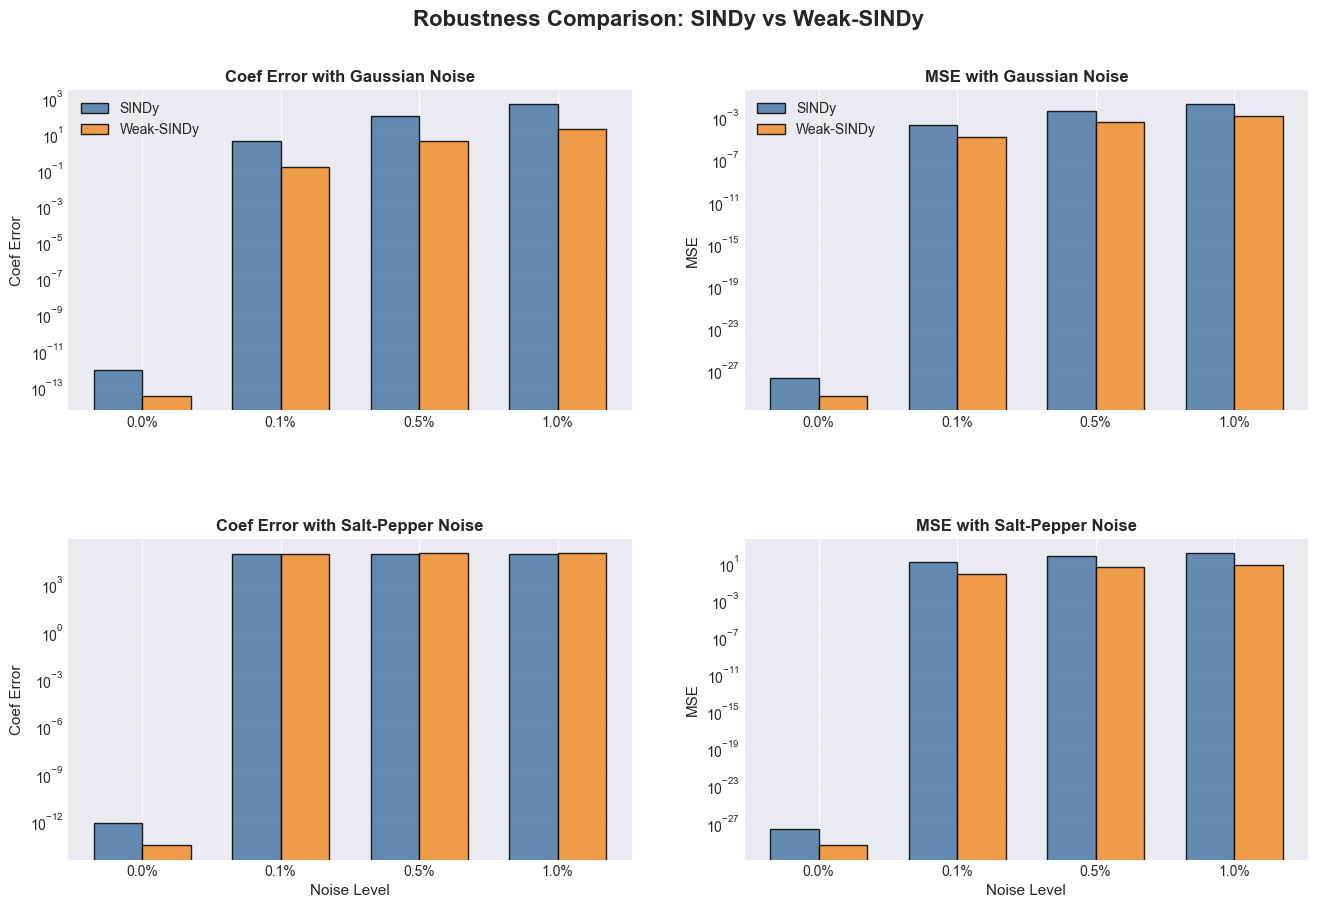

In [22]:
import matplotlib.pyplot as plt
import numpy as np

# Set up the figure
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
plt.subplots_adjust(hspace=0.4, wspace=0.2)

# --- Data Preparation ---
# Filter data for Gaussian
g_mask = np.array([nt in ['Clean', 'Gaussian'] for nt in results['noise_type']])
g_levels = np.array(results['noise_level'])[g_mask]
g_data = {
    'Coef Error': (np.array(results['sindy_coef_error'])[g_mask], np.array(results['weak_coef_error'])[g_mask]),
    'MSE': (np.array(results['sindy_mse'])[g_mask], np.array(results['weak_mse'])[g_mask])
}

# Filter data for Salt-Pepper
sp_mask = np.array([nt in ['Clean', 'Salt-Pepper'] for nt in results['noise_type']])
sp_levels = np.array(results['noise_level'])[sp_mask]
sp_data = {
    'Coef Error': (np.array(results['sindy_coef_error'])[sp_mask], np.array(results['weak_coef_error'])[sp_mask]),
    'MSE': (np.array(results['sindy_mse'])[sp_mask], np.array(results['weak_mse'])[sp_mask])
}

# Configuration for the loop
plot_configs = [
    # Row 0: Gaussian
    {'title': 'Gaussian', 'levels': g_levels, 'data': g_data, 'row': 0},
    # Row 1: Salt-Pepper
    {'title': 'Salt-Pepper', 'levels': sp_levels, 'data': sp_data, 'row': 1}
]

bar_width = 0.35
opacity = 0.85

# --- Plotting Loop ---
for config in plot_configs:
    row = config['row']
    levels = config['levels']
    x_indices = np.arange(len(levels))  # categorical x-axis

    # Column 0: Coefficient Error | Column 1: MSE
    for col, metric in enumerate(['Coef Error', 'MSE']):
        ax = axes[row, col]
        
        sindy_vals, weak_vals = config['data'][metric]
        
        # Create grouped bars
        rects1 = ax.bar(x_indices - bar_width/2, sindy_vals, bar_width, 
                        alpha=opacity, color='#4e79a7', label='SINDy', edgecolor='black')
        rects2 = ax.bar(x_indices + bar_width/2, weak_vals, bar_width, 
                        alpha=opacity, color='#f28e2b', label='Weak-SINDy', edgecolor='black')
        
        # Formatting
        ax.set_title(f'{metric} with {config["title"]} Noise', fontsize=12, fontweight='bold')
        ax.set_ylabel(metric, fontsize=11)
        ax.set_yscale('log') # Log scale is crucial for error plots
        
        # X-axis formatting
        ax.set_xticks(x_indices)
        ax.set_xticklabels([f'{x}%' for x in levels])
        if row == 1:
            ax.set_xlabel('Noise Level', fontsize=11)
            
        # Grid and Legend
        ax.grid(True, which='both', axis='y', linestyle='--', alpha=0.3)
        if row == 0 and col == 1: # Put legend in top right plot only to save space
            ax.legend(fontsize=10, loc='best')
        elif row == 0 and col == 0:
             ax.legend(fontsize=10, loc='best')

# Overall Title
plt.suptitle('Robustness Comparison: SINDy vs Weak-SINDy', fontsize=16, fontweight='bold', y=0.96)

plt.show()

Simulating 2000 steps...
Simulation complete.

TESTING NOISE ROBUSTNESS WITH ADAPTIVE DENOISING

--- CLEAN DATA (No Noise) ---
SINDy:      Coef Error = 0.000000, MSE = 2.259001e-28
Weak-SINDy: Coef Error = 0.000000, MSE = 4.301264e-30

GAUSSIAN NOISE: 0.1%

--- Without Denoising ---
SINDy:      Coef Error = 4.273362, MSE = 1.821570e-04
Weak-SINDy: Coef Error = 0.151446, MSE = 1.385271e-05

--- With Adaptive Denoising ---
SINDy:      Coef Error = 4.010498, MSE = 4.477099e-04
Weak-SINDy: Coef Error = 0.416970, MSE = 2.938642e-06

GAUSSIAN NOISE: 0.5%

--- Without Denoising ---
SINDy:      Coef Error = 109.864144, MSE = 4.551605e-03
Weak-SINDy: Coef Error = 4.425890, MSE = 3.463122e-04

--- With Adaptive Denoising ---
SINDy:      Coef Error = 4.940567, MSE = 1.441170e-03
Weak-SINDy: Coef Error = 1.042712, MSE = 7.284765e-05

GAUSSIAN NOISE: 1.0%

--- Without Denoising ---
SINDy:      Coef Error = 476.211560, MSE = 1.817695e-02
Weak-SINDy: Coef Error = 19.457626, MSE = 1.385180e-03

--- Wi

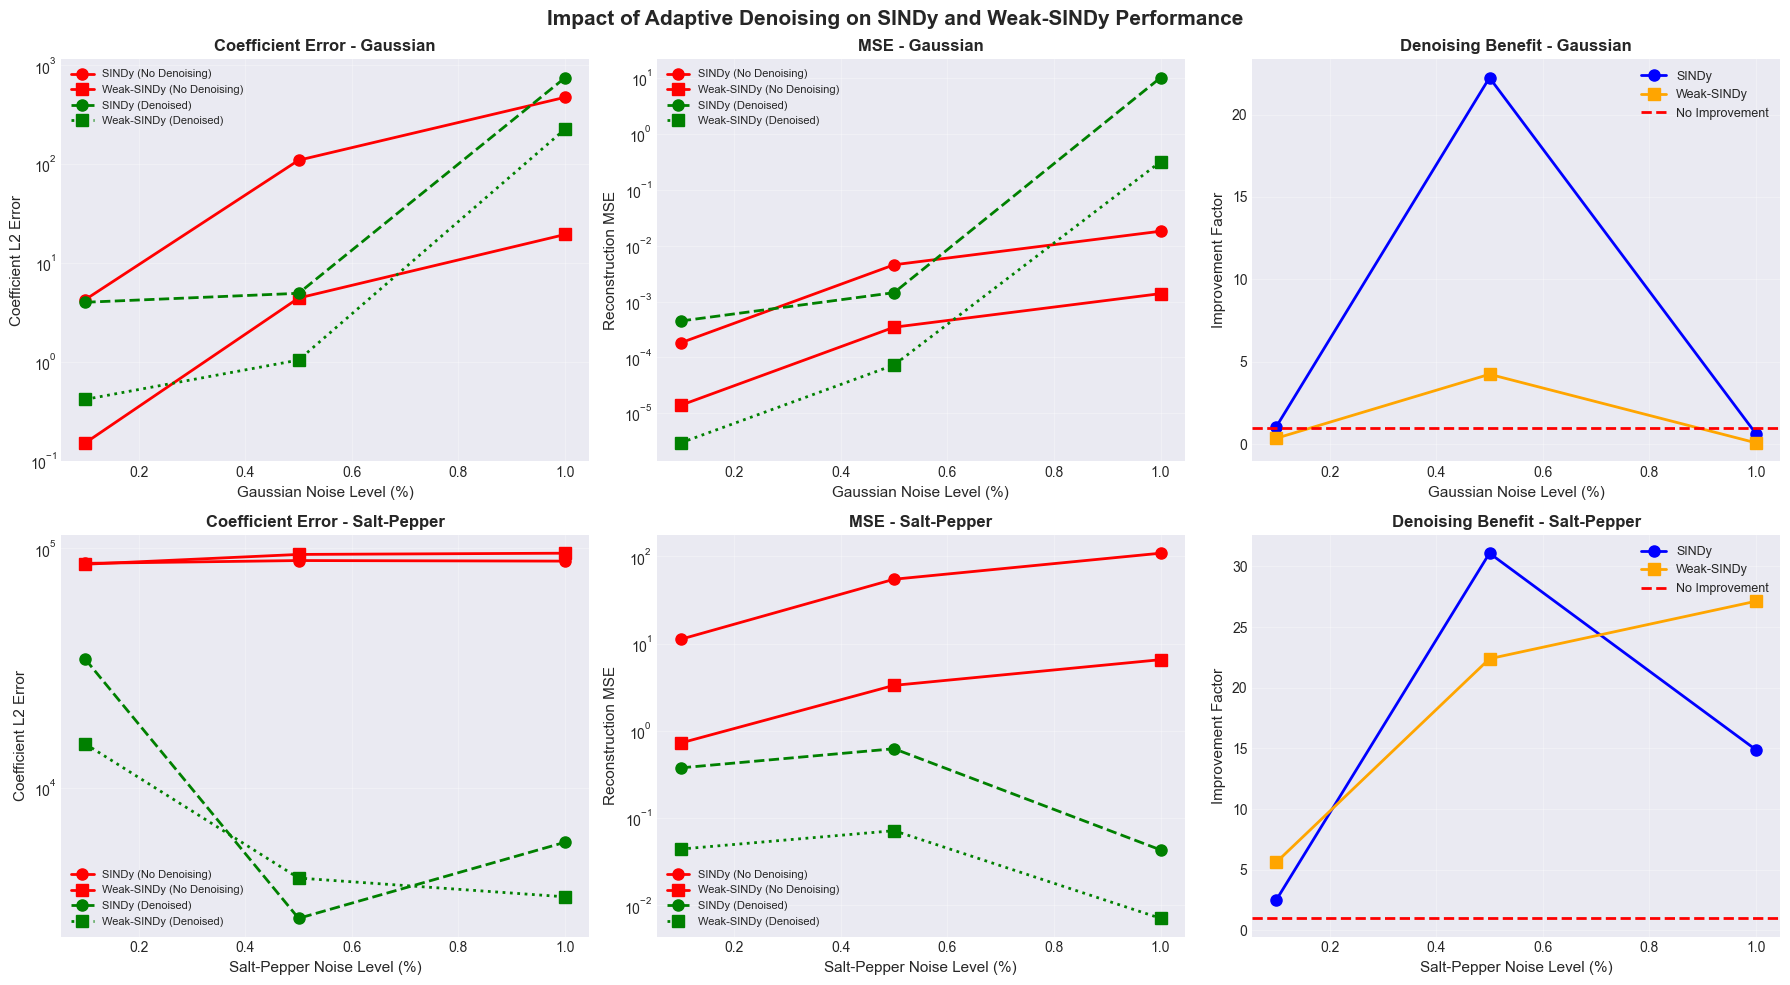


SUMMARY
Adaptive Denoising Strategy:
- Low noise (0.1%): Savitzky-Golay temporal smoothing only
- Medium noise (0.5%): Temporal + very light spatial smoothing
- High noise (1.0%): Temporal + spatial + Total Variation

Improvement Factor > 1.0: Denoising helped
Improvement Factor < 1.0: Denoising hurt


In [23]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import convolve, median_filter, gaussian_filter
from scipy.signal import savgol_filter

# --- Configuration ---
Lx, Ly = 50, 50       
Nx, Ny = 100, 100
dt = 0.001
n_seconds = 2.0
save_every = 1

# Derived parameters
dx = Lx / Nx
dy = Ly / Ny
total_steps = int(n_seconds / dt)
n_frames = total_steps // save_every

# --- Generate Simulation Data ---
x = np.linspace(0, Lx, Nx)
y = np.linspace(0, Ly, Ny)
X, Y = np.meshgrid(x, y)

np.random.seed(42)
u = np.random.uniform(-0.1, 0.1, (Nx, Ny))

u_data = np.zeros((n_frames, Nx, Ny))
t_data = np.zeros(n_frames)

def get_laplacian(f):
    return (np.roll(f, -1, axis=0) + np.roll(f, 1, axis=0) +
            np.roll(f, -1, axis=1) + np.roll(f, 1, axis=1) - 4*f) / (dx**2)

def get_gradients(f):
    gx = (np.roll(f, -1, axis=0) - np.roll(f, 1, axis=0)) / (2*dx)
    gy = (np.roll(f, -1, axis=1) - np.roll(f, 1, axis=1)) / (2*dy)
    return gx, gy

def compute_rhs(u):
    lap = get_laplacian(u)
    lap_lap = get_laplacian(lap)
    gx, gy = get_gradients(u)
    return -lap - lap_lap - 0.5*(gx**2 + gy**2)

print(f"Simulating {total_steps} steps...")
current_u = u.copy()
frame_idx = 0
for step in range(total_steps):
    rhs = compute_rhs(current_u)
    current_u += dt * rhs
    current_u = np.nan_to_num(current_u)
    if step % save_every == 0:
        u_data[frame_idx, :, :] = current_u.copy()
        t_data[frame_idx] = step * dt
        frame_idx += 1
print("Simulation complete.\n")

u_data_clean = u_data.copy()

# --- Noise Addition Functions ---
def add_gaussian_noise(data, noise_percent):
    noise_level = noise_percent / 100.0
    signal_std = np.std(data)
    noise = noise_level * signal_std * np.random.randn(*data.shape)
    return data + noise

def add_salt_pepper_noise(data, noise_percent):
    noisy = data.copy()
    noise_fraction = noise_percent / 100.0
    
    num_salt = int(noise_fraction * data.size / 2)
    coords_salt = [np.random.randint(0, i, num_salt) for i in data.shape]
    noisy[tuple(coords_salt)] = np.max(data)
    
    num_pepper = int(noise_fraction * data.size / 2)
    coords_pepper = [np.random.randint(0, i, num_pepper) for i in data.shape]
    noisy[tuple(coords_pepper)] = np.min(data)
    
    return noisy

# --- IMPROVED DENOISING METHODS ---
def denoise_savitzky_golay_temporal(data, window_length=5, polyorder=2):
    """Apply Savitzky-Golay filter along time dimension - preserves features better"""
    denoised = np.zeros_like(data)
    n_frames, nx, ny = data.shape
    
    # Apply to each spatial point along time
    for i in range(nx):
        for j in range(ny):
            time_series = data[:, i, j]
            if window_length <= len(time_series):
                denoised[:, i, j] = savgol_filter(time_series, window_length, polyorder)
            else:
                denoised[:, i, j] = time_series
    return denoised

def denoise_light_spatial(data, sigma=0.3):
    """Very light spatial smoothing - just enough to reduce high-freq noise"""
    denoised = np.zeros_like(data)
    for i in range(data.shape[0]):
        denoised[i] = gaussian_filter(data[i], sigma=sigma)
    return denoised

def denoise_median_light(data, size=2):
    """Light median filter for impulse noise"""
    denoised = np.zeros_like(data)
    for i in range(data.shape[0]):
        denoised[i] = median_filter(data[i], size=size)
    return denoised

def denoise_total_variation(data, weight=0.05, n_iter=3):
    """Total Variation denoising - preserves edges while removing noise"""
    from scipy.ndimage import laplace
    
    denoised = data.copy()
    for frame_idx in range(data.shape[0]):
        img = denoised[frame_idx].copy()
        for _ in range(n_iter):
            # Compute gradient magnitude
            grad_x = np.gradient(img, axis=0)
            grad_y = np.gradient(img, axis=1)
            grad_mag = np.sqrt(grad_x**2 + grad_y**2) + 1e-8
            
            # Update with TV regularization
            div_x = np.gradient(grad_x / grad_mag, axis=0)
            div_y = np.gradient(grad_y / grad_mag, axis=1)
            img = img + weight * (div_x + div_y)
        
        denoised[frame_idx] = img
    return denoised

def denoise_adaptive(data, noise_type='gaussian', noise_level=0.1):
    """Adaptive denoising based on noise type and level"""
    if noise_type == 'gaussian':
        if noise_level <= 0.1:
            # Very light: just temporal smoothing
            return denoise_savitzky_golay_temporal(data, window_length=5, polyorder=2)
        elif noise_level <= 0.5:
            # Medium: temporal + very light spatial
            denoised = denoise_savitzky_golay_temporal(data, window_length=5, polyorder=2)
            return denoise_light_spatial(denoised, sigma=0.3)
        else:
            # Higher: temporal + spatial + TV
            denoised = denoise_savitzky_golay_temporal(data, window_length=7, polyorder=2)
            denoised = denoise_light_spatial(denoised, sigma=0.5)
            return denoise_total_variation(denoised, weight=0.05, n_iter=2)
    else:  # salt-pepper
        if noise_level <= 0.1:
            # Light median only
            return denoise_median_light(data, size=2)
        elif noise_level <= 0.5:
            # Median + temporal
            denoised = denoise_median_light(data, size=2)
            return denoise_savitzky_golay_temporal(denoised, window_length=5, polyorder=2)
        else:
            # Stronger median + temporal
            denoised = denoise_median_light(data, size=3)
            return denoise_savitzky_golay_temporal(denoised, window_length=7, polyorder=2)

# --- Library Functions ---
def build_library(u_data):
    n_frames, nx, ny = u_data.shape
    n_samples = n_frames * nx * ny
    
    u_flat = u_data.reshape(n_samples)
    
    lib_features = []
    feature_names = []
    
    lib_features.append(np.ones(n_samples))
    feature_names.append('1')
    
    lib_features.append(u_flat)
    feature_names.append('u')
    lib_features.append(u_flat**2)
    feature_names.append('u²')
    lib_features.append(u_flat**3)
    feature_names.append('u³')
    
    lap_all = np.zeros_like(u_data)
    bilap_all = np.zeros_like(u_data)
    gx_all = np.zeros_like(u_data)
    gy_all = np.zeros_like(u_data)
    
    for i in range(n_frames):
        lap_all[i] = get_laplacian(u_data[i])
        bilap_all[i] = get_laplacian(lap_all[i])
        gx_all[i], gy_all[i] = get_gradients(u_data[i])
    
    lib_features.append(lap_all.reshape(n_samples))
    feature_names.append('∇²u')
    lib_features.append(bilap_all.reshape(n_samples))
    feature_names.append('∇⁴u')
    lib_features.append((gx_all**2 + gy_all**2).reshape(n_samples))
    feature_names.append('|∇u|²')
    lib_features.append((u_data * lap_all).reshape(n_samples))
    feature_names.append('u∇²u')
    
    Theta = np.column_stack(lib_features)
    return Theta, feature_names

# --- SINDy Method ---
def sindy_method(u_data, t_data, threshold=0.05):
    dt_data = np.diff(t_data).mean()
    u_dot = np.zeros_like(u_data[:-1])
    for i in range(len(u_data) - 1):
        u_dot[i] = (u_data[i+1] - u_data[i]) / dt_data
    
    Theta, feature_names = build_library(u_data[:-1])
    u_dot_flat = u_dot.reshape(-1)
    
    coeffs = np.linalg.lstsq(Theta, u_dot_flat, rcond=None)[0]
    
    for _ in range(10):
        small_inds = np.abs(coeffs) < threshold
        coeffs[small_inds] = 0
        big_inds = ~small_inds
        if np.sum(big_inds) == 0:
            break
        coeffs[big_inds] = np.linalg.lstsq(Theta[:, big_inds], u_dot_flat, rcond=None)[0]
    
    prediction = Theta @ coeffs
    error = np.mean((prediction - u_dot_flat)**2)
    
    return coeffs, feature_names, error

# --- Weak SINDy Method ---
def weak_sindy_method(u_data, t_data, threshold=0.05, kernel_size=5):
    n_frames, nx, ny = u_data.shape
    
    def gaussian_kernel_2d(size, sigma):
        kernel = np.zeros((size, size))
        center = size // 2
        for i in range(size):
            for j in range(size):
                x, y = i - center, j - center
                kernel[i, j] = np.exp(-(x**2 + y**2) / (2 * sigma**2))
        return kernel / kernel.sum()
    
    test_func = gaussian_kernel_2d(kernel_size, kernel_size/4)
    
    u_weak = np.zeros((n_frames, nx, ny))
    for i in range(n_frames):
        u_weak[i] = convolve(u_data[i], test_func, mode='wrap')
    
    dt_data = np.diff(t_data).mean()
    u_dot_weak = np.zeros_like(u_weak[:-1])
    for i in range(len(u_weak) - 1):
        u_dot_weak[i] = (u_weak[i+1] - u_weak[i]) / dt_data
    
    Theta_weak = []
    feature_names_weak = ['1', 'u', 'u²', 'u³', '∇²u', '∇⁴u', '|∇u|²', 'u∇²u']
    
    for frame_idx in range(n_frames - 1):
        frame_features = []
        
        frame_features.append(np.sum(test_func) * np.ones((nx, ny)))
        frame_features.append(u_weak[frame_idx])
        frame_features.append(convolve(u_data[frame_idx]**2, test_func, mode='wrap'))
        frame_features.append(convolve(u_data[frame_idx]**3, test_func, mode='wrap'))
        
        lap = get_laplacian(u_data[frame_idx])
        bilap = get_laplacian(lap)
        gx, gy = get_gradients(u_data[frame_idx])
        
        frame_features.append(convolve(lap, test_func, mode='wrap'))
        frame_features.append(convolve(bilap, test_func, mode='wrap'))
        frame_features.append(convolve(gx**2 + gy**2, test_func, mode='wrap'))
        frame_features.append(convolve(u_data[frame_idx] * lap, test_func, mode='wrap'))
        
        Theta_weak.append(np.column_stack([f.reshape(-1) for f in frame_features]))
    
    Theta_weak = np.vstack(Theta_weak)
    u_dot_weak_flat = u_dot_weak.reshape(-1)
    
    coeffs = np.linalg.lstsq(Theta_weak, u_dot_weak_flat, rcond=None)[0]
    
    for _ in range(10):
        small_inds = np.abs(coeffs) < threshold
        coeffs[small_inds] = 0
        big_inds = ~small_inds
        if np.sum(big_inds) == 0:
            break
        coeffs[big_inds] = np.linalg.lstsq(Theta_weak[:, big_inds], u_dot_weak_flat, rcond=None)[0]
    
    prediction = Theta_weak @ coeffs
    error = np.mean((prediction - u_dot_weak_flat)**2)
    
    return coeffs, feature_names_weak, error

# --- Compute coefficient error ---
def compute_coef_error(coeffs, names):
    ground_truth = {'1': 0, 'u': 0, 'u²': 0, 'u³': 0, 
                    '∇²u': -1.0, '∇⁴u': -1.0, '|∇u|²': -0.5, 'u∇²u': 0}
    gt_vals = np.array([ground_truth.get(name, 0) for name in names])
    return np.linalg.norm(gt_vals - coeffs)

# --- Test Different Noise Levels with Denoising ---
print("=" * 80)
print("TESTING NOISE ROBUSTNESS WITH ADAPTIVE DENOISING")
print("=" * 80)

gaussian_levels = [0.1, 0.5, 1.0]
sp_levels = [0.1, 0.5, 1.0]

results = {
    'noise_type': [],
    'noise_level': [],
    'method': [],
    'sindy_coef_error': [],
    'weak_coef_error': [],
    'sindy_mse': [],
    'weak_mse': []
}

# Clean data baseline
print("\n--- CLEAN DATA (No Noise) ---")
sindy_coeffs, sindy_names, sindy_error = sindy_method(u_data_clean, t_data)
weak_coeffs, weak_names, weak_error = weak_sindy_method(u_data_clean, t_data)
sindy_coef_err = compute_coef_error(sindy_coeffs, sindy_names)
weak_coef_err = compute_coef_error(weak_coeffs, weak_names)
print(f"SINDy:      Coef Error = {sindy_coef_err:.6f}, MSE = {sindy_error:.6e}")
print(f"Weak-SINDy: Coef Error = {weak_coef_err:.6f}, MSE = {weak_error:.6e}")

results['noise_type'].append('Clean')
results['noise_level'].append(0.0)
results['method'].append('None')
results['sindy_coef_error'].append(sindy_coef_err)
results['weak_coef_error'].append(weak_coef_err)
results['sindy_mse'].append(sindy_error)
results['weak_mse'].append(weak_error)

# Gaussian noise tests
for noise_level in gaussian_levels:
    print(f"\n{'='*80}")
    print(f"GAUSSIAN NOISE: {noise_level}%")
    print(f"{'='*80}")
    
    np.random.seed(123)
    u_data_noisy = add_gaussian_noise(u_data_clean, noise_level)
    
    # Without denoising
    print("\n--- Without Denoising ---")
    sindy_coeffs, sindy_names, sindy_error = sindy_method(u_data_noisy, t_data, threshold=0.1)
    weak_coeffs, weak_names, weak_error = weak_sindy_method(u_data_noisy, t_data, threshold=0.1)
    sindy_coef_err = compute_coef_error(sindy_coeffs, sindy_names)
    weak_coef_err = compute_coef_error(weak_coeffs, weak_names)
    print(f"SINDy:      Coef Error = {sindy_coef_err:.6f}, MSE = {sindy_error:.6e}")
    print(f"Weak-SINDy: Coef Error = {weak_coef_err:.6f}, MSE = {weak_error:.6e}")
    
    results['noise_type'].append('Gaussian')
    results['noise_level'].append(noise_level)
    results['method'].append('No Denoising')
    results['sindy_coef_error'].append(sindy_coef_err)
    results['weak_coef_error'].append(weak_coef_err)
    results['sindy_mse'].append(sindy_error)
    results['weak_mse'].append(weak_error)
    
    # With adaptive denoising
    print("\n--- With Adaptive Denoising ---")
    u_data_denoised = denoise_adaptive(u_data_noisy, noise_type='gaussian', noise_level=noise_level)
    sindy_coeffs, sindy_names, sindy_error = sindy_method(u_data_denoised, t_data, threshold=0.1)
    weak_coeffs, weak_names, weak_error = weak_sindy_method(u_data_denoised, t_data, threshold=0.1)
    sindy_coef_err = compute_coef_error(sindy_coeffs, sindy_names)
    weak_coef_err = compute_coef_error(weak_coeffs, weak_names)
    print(f"SINDy:      Coef Error = {sindy_coef_err:.6f}, MSE = {sindy_error:.6e}")
    print(f"Weak-SINDy: Coef Error = {weak_coef_err:.6f}, MSE = {weak_error:.6e}")
    
    results['noise_type'].append('Gaussian')
    results['noise_level'].append(noise_level)
    results['method'].append('Denoised')
    results['sindy_coef_error'].append(sindy_coef_err)
    results['weak_coef_error'].append(weak_coef_err)
    results['sindy_mse'].append(sindy_error)
    results['weak_mse'].append(weak_error)

# Salt-and-pepper noise tests
for noise_level in sp_levels:
    print(f"\n{'='*80}")
    print(f"SALT-AND-PEPPER NOISE: {noise_level}%")
    print(f"{'='*80}")
    
    np.random.seed(456)
    u_data_noisy = add_salt_pepper_noise(u_data_clean, noise_level)
    
    # Without denoising
    print("\n--- Without Denoising ---")
    sindy_coeffs, sindy_names, sindy_error = sindy_method(u_data_noisy, t_data, threshold=0.1)
    weak_coeffs, weak_names, weak_error = weak_sindy_method(u_data_noisy, t_data, threshold=0.1)
    sindy_coef_err = compute_coef_error(sindy_coeffs, sindy_names)
    weak_coef_err = compute_coef_error(weak_coeffs, weak_names)
    print(f"SINDy:      Coef Error = {sindy_coef_err:.6f}, MSE = {sindy_error:.6e}")
    print(f"Weak-SINDy: Coef Error = {weak_coef_err:.6f}, MSE = {weak_error:.6e}")
    
    results['noise_type'].append('Salt-Pepper')
    results['noise_level'].append(noise_level)
    results['method'].append('No Denoising')
    results['sindy_coef_error'].append(sindy_coef_err)
    results['weak_coef_error'].append(weak_coef_err)
    results['sindy_mse'].append(sindy_error)
    results['weak_mse'].append(weak_error)
    
    # With adaptive denoising
    print("\n--- With Adaptive Denoising ---")
    u_data_denoised = denoise_adaptive(u_data_noisy, noise_type='salt-pepper', noise_level=noise_level)
    sindy_coeffs, sindy_names, sindy_error = sindy_method(u_data_denoised, t_data, threshold=0.1)
    weak_coeffs, weak_names, weak_error = weak_sindy_method(u_data_denoised, t_data, threshold=0.1)
    sindy_coef_err = compute_coef_error(sindy_coeffs, sindy_names)
    weak_coef_err = compute_coef_error(weak_coeffs, weak_names)
    print(f"SINDy:      Coef Error = {sindy_coef_err:.6f}, MSE = {sindy_error:.6e}")
    print(f"Weak-SINDy: Coef Error = {weak_coef_err:.6f}, MSE = {weak_error:.6e}")
    
    results['noise_type'].append('Salt-Pepper')
    results['noise_level'].append(noise_level)
    results['method'].append('Denoised')
    results['sindy_coef_error'].append(sindy_coef_err)
    results['weak_coef_error'].append(weak_coef_err)
    results['sindy_mse'].append(sindy_error)
    results['weak_mse'].append(weak_error)

# --- Enhanced Visualization ---
fig = plt.figure(figsize=(18, 10))

noise_types = ['Gaussian', 'Salt-Pepper']
colors = {'No Denoising': 'red', 'Denoised': 'green'}
markers = {'SINDy': 'o', 'Weak-SINDy': 's'}

for idx, nt in enumerate(noise_types):
    mask = np.array(results['noise_type']) == nt
    levels = np.array(results['noise_level'])[mask]
    methods = np.array(results['method'])[mask]
    
    unique_levels = sorted(set(levels[levels > 0]))
    
    # Coefficient Error comparison
    ax1 = plt.subplot(2, 3, idx*3 + 1)
    for method in ['No Denoising', 'Denoised']:
        method_mask = methods == method
        method_levels = levels[method_mask]
        sindy_errs = np.array(results['sindy_coef_error'])[mask][method_mask]
        weak_errs = np.array(results['weak_coef_error'])[mask][method_mask]
        
        ax1.plot(method_levels, sindy_errs, marker=markers['SINDy'], 
                label=f'SINDy ({method})', linewidth=2, markersize=8, 
                color=colors[method], linestyle='-' if method == 'No Denoising' else '--')
        ax1.plot(method_levels, weak_errs, marker=markers['Weak-SINDy'], 
                label=f'Weak-SINDy ({method})', linewidth=2, markersize=8, 
                color=colors[method], linestyle='-' if method == 'No Denoising' else ':')
    
    ax1.set_xlabel(f'{nt} Noise Level (%)', fontsize=11)
    ax1.set_ylabel('Coefficient L2 Error', fontsize=11)
    ax1.set_title(f'Coefficient Error - {nt}', fontsize=12, fontweight='bold')
    ax1.legend(fontsize=8)
    ax1.grid(True, alpha=0.3)
    ax1.set_yscale('log')
    
    # MSE comparison
    ax2 = plt.subplot(2, 3, idx*3 + 2)
    for method in ['No Denoising', 'Denoised']:
        method_mask = methods == method
        method_levels = levels[method_mask]
        sindy_mse = np.array(results['sindy_mse'])[mask][method_mask]
        weak_mse = np.array(results['weak_mse'])[mask][method_mask]
        
        ax2.plot(method_levels, sindy_mse, marker=markers['SINDy'], 
                label=f'SINDy ({method})', linewidth=2, markersize=8, 
                color=colors[method], linestyle='-' if method == 'No Denoising' else '--')
        ax2.plot(method_levels, weak_mse, marker=markers['Weak-SINDy'], 
                label=f'Weak-SINDy ({method})', linewidth=2, markersize=8, 
                color=colors[method], linestyle='-' if method == 'No Denoising' else ':')
    
    ax2.set_xlabel(f'{nt} Noise Level (%)', fontsize=11)
    ax2.set_ylabel('Reconstruction MSE', fontsize=11)
    ax2.set_title(f'MSE - {nt}', fontsize=12, fontweight='bold')
    ax2.legend(fontsize=8)
    ax2.grid(True, alpha=0.3)
    ax2.set_yscale('log')
    
    # Improvement factor
    ax3 = plt.subplot(2, 3, idx*3 + 3)
    no_denoise_mask = (methods == 'No Denoising') & (levels > 0)
    denoised_mask = (methods == 'Denoised') & (levels > 0)
    
    no_denoise_sindy = np.array(results['sindy_coef_error'])[mask][no_denoise_mask]
    denoised_sindy = np.array(results['sindy_coef_error'])[mask][denoised_mask]
    no_denoise_weak = np.array(results['weak_coef_error'])[mask][no_denoise_mask]
    denoised_weak = np.array(results['weak_coef_error'])[mask][denoised_mask]
    
    improvement_sindy = no_denoise_sindy / (denoised_sindy + 1e-10)
    improvement_weak = no_denoise_weak / (denoised_weak + 1e-10)
    
    ax3.plot(unique_levels, improvement_sindy, marker='o', 
            label='SINDy', linewidth=2, markersize=8, color='blue')
    ax3.plot(unique_levels, improvement_weak, marker='s', 
            label='Weak-SINDy', linewidth=2, markersize=8, color='orange')
    ax3.axhline(y=1.0, color='red', linestyle='--', linewidth=2, label='No Improvement')
    
    ax3.set_xlabel(f'{nt} Noise Level (%)', fontsize=11)
    ax3.set_ylabel('Improvement Factor', fontsize=11)
    ax3.set_title(f'Denoising Benefit - {nt}', fontsize=12, fontweight='bold')
    ax3.legend(fontsize=9)
    ax3.grid(True, alpha=0.3)

plt.suptitle('Impact of Adaptive Denoising on SINDy and Weak-SINDy Performance', 
             fontsize=15, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n" + "=" * 80)
print("SUMMARY")
print("=" * 80)
print("Adaptive Denoising Strategy:")
print("- Low noise (0.1%): Savitzky-Golay temporal smoothing only")
print("- Medium noise (0.5%): Temporal + very light spatial smoothing")
print("- High noise (1.0%): Temporal + spatial + Total Variation")
print("\nImprovement Factor > 1.0: Denoising helped")
print("Improvement Factor < 1.0: Denoising hurt")
print("=" * 80)

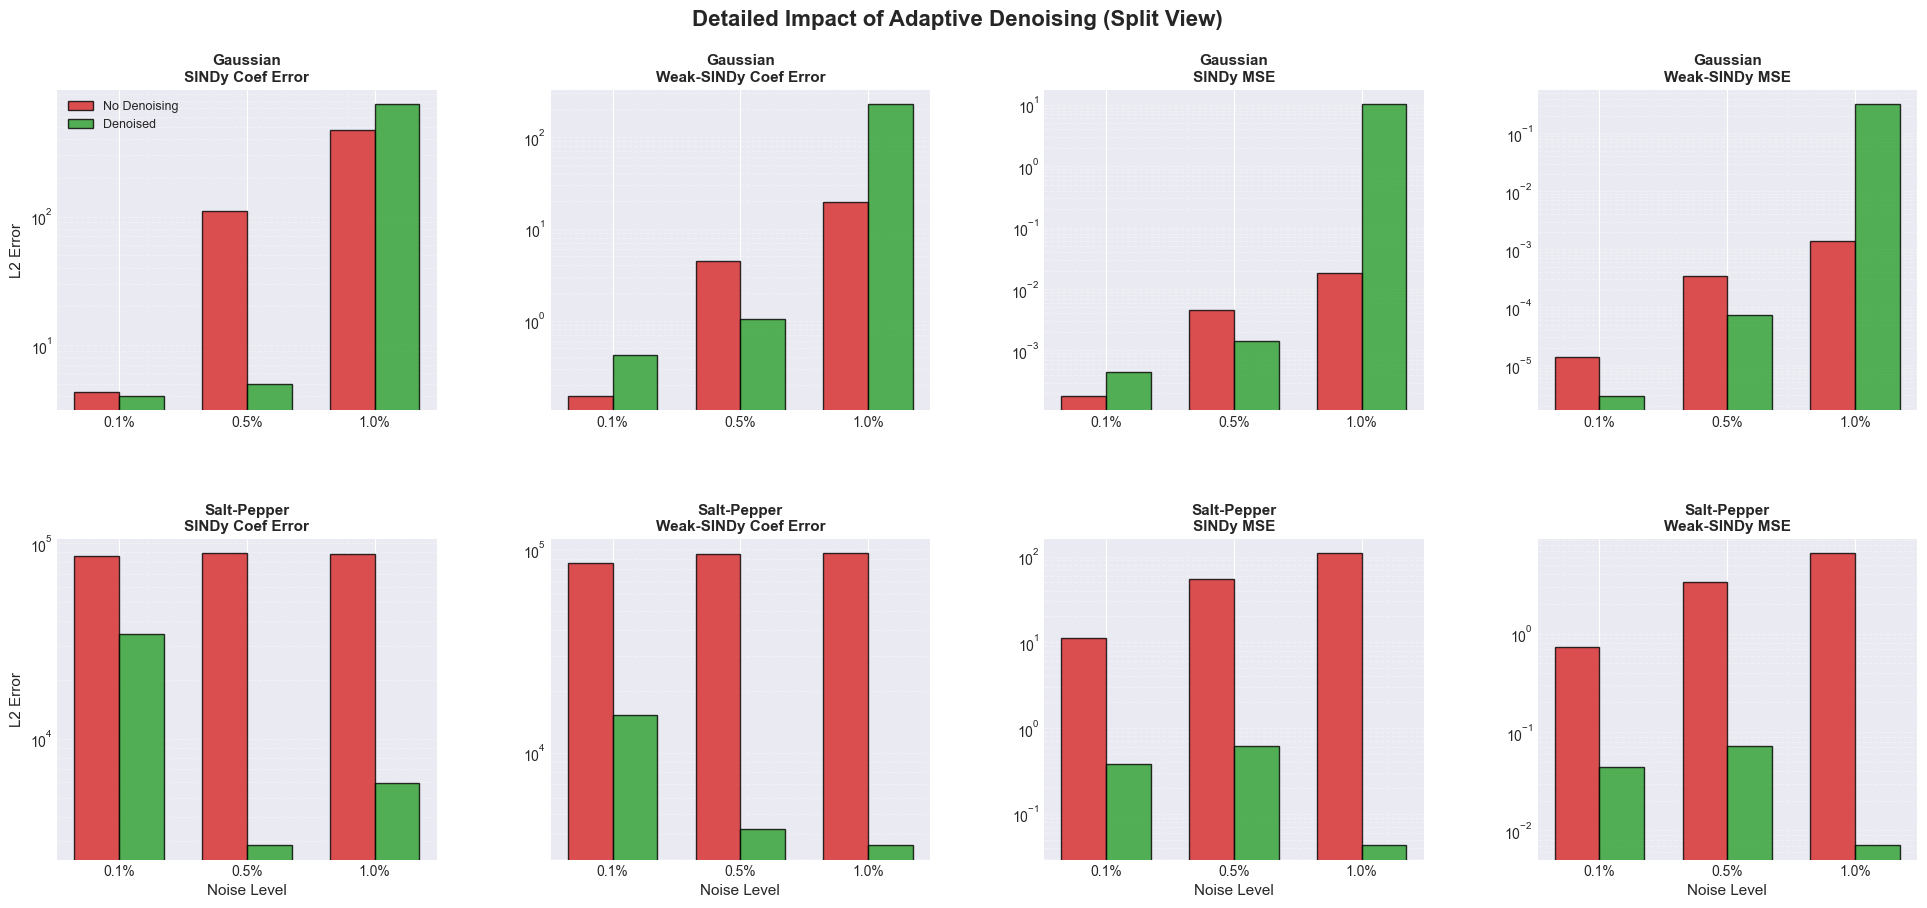

In [26]:
import matplotlib.pyplot as plt
import numpy as np

# Set up the figure: 2 rows (Noise Types), 4 columns (Method/Metric combinations)
fig, axes = plt.subplots(2, 4, figsize=(24, 10))
plt.subplots_adjust(hspace=0.4, wspace=0.3)

noise_types = ['Gaussian', 'Salt-Pepper']
# Define the 4 columns for each row
plot_defs = [
    {'key': 'sindy_coef_error', 'title': 'SINDy Coef Error', 'ylabel': 'L2 Error'},
    {'key': 'weak_coef_error',  'title': 'Weak-SINDy Coef Error', 'ylabel': 'L2 Error'},
    {'key': 'sindy_mse',        'title': 'SINDy MSE', 'ylabel': 'MSE'},
    {'key': 'weak_mse',         'title': 'Weak-SINDy MSE', 'ylabel': 'MSE'}
]

# Visual configs
bar_width = 0.35
c_raw = '#d62728'      # Red
c_denoised = '#2ca02c' # Green

for row_idx, nt in enumerate(noise_types):
    # 1. Filter data for the current Noise Type
    base_mask = np.array(results['noise_type']) == nt
    
    # Get unique noise levels (excluding 0 if desired, or keeping it)
    current_levels = np.array(results['noise_level'])[base_mask]
    # Filter out 0% noise if it messes up log plots, otherwise keep it
    unique_levels = sorted(list(set(current_levels[current_levels > 0])))
    x_indices = np.arange(len(unique_levels))
    
    # 2. Loop through the 4 distinct charts (SINDy Coef, Weak Coef, SINDy MSE, Weak MSE)
    for col_idx, p_def in enumerate(plot_defs):
        ax = axes[row_idx, col_idx]
        data_key = p_def['key']
        
        raw_means = []
        denoised_means = []
        
        # Aggregate data per level
        for level in unique_levels:
            # Mask for specific level + noise type
            lvl_mask = base_mask & (np.array(results['noise_level']) == level)
            
            # Get Raw (No Denoising) value
            raw_mask = lvl_mask & (np.array(results['method']) == 'No Denoising')
            val_raw = np.array(results[data_key])[raw_mask]
            raw_means.append(np.mean(val_raw) if len(val_raw) > 0 else 0)
            
            # Get Denoised value
            denoised_mask = lvl_mask & (np.array(results['method']) == 'Denoised')
            val_den = np.array(results[data_key])[denoised_mask]
            denoised_means.append(np.mean(val_den) if len(val_den) > 0 else 0)
            
        # Plot Bars
        ax.bar(x_indices - bar_width/2, raw_means, bar_width, 
               label='No Denoising', color=c_raw, alpha=0.8, edgecolor='black')
        ax.bar(x_indices + bar_width/2, denoised_means, bar_width, 
               label='Denoised', color=c_denoised, alpha=0.8, edgecolor='black')
        
        # Formatting
        ax.set_title(f"{nt}\n{p_def['title']}", fontsize=11, fontweight='bold')
        ax.set_yscale('log')
        ax.set_xticks(x_indices)
        ax.set_xticklabels([f'{x}%' for x in unique_levels])
        ax.grid(True, which='both', axis='y', linestyle='--', alpha=0.3)
        
        # Labels
        if col_idx == 0:
            ax.set_ylabel(p_def['ylabel'], fontsize=11)
        if row_idx == 1:
            ax.set_xlabel('Noise Level', fontsize=11)
            
        # Legend: Only on the very first plot to keep it clean
        if row_idx == 0 and col_idx == 0:
            ax.legend(fontsize=9, loc='upper left')

plt.suptitle('Detailed Impact of Adaptive Denoising (Split View)', fontsize=16, fontweight='bold', y=0.96)
plt.show()